In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import transforms, utils, models, datasets
from torch.utils.data import Dataset, DataLoader

In [4]:
from synthetic_utils import *

In [5]:
from trainer_dataloader import *
from networks import *
from losses import *

In [6]:
input_size = 96
batch_size = 128
num_workers = 4
num_epochs = 20

In [7]:
cuda = False
pin_memory = False
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    cuda = True
    cudnn.benchmark = True
    pin_memory = True
else:
    device = torch.device("cpu")

print('Device set: {}'.format(device))

Device set: cuda


In [8]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((input_size, input_size)),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]),
        'val': transforms.Compose([
            transforms.Resize((input_size, input_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
}

In [9]:
DATA_PATH = '/home/var/synthetic_data/gen_shapes/'
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
VAL_PATH = os.path.join(DATA_PATH, 'valid')
TEST_PATH = os.path.join(DATA_PATH, 'test')

In [10]:
train_df = datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train'])
val_df = datasets.ImageFolder(root=VAL_PATH, transform=data_transforms['val'])
test_df = datasets.ImageFolder(root=TEST_PATH, transform=data_transforms['val'])

In [11]:
train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_df, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

## Train only encoder first


In [12]:
encoder = LeNet()
classifier = ClassNet()

In [13]:
criterion = nn.BCELoss()
opt_cls = optim.Adam(classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_enc = optim.Adam(encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_cls = lr_scheduler.StepLR(optimizer=opt_cls, gamma=0.99, step_size=1)
scheduler_enc = lr_scheduler.StepLR(optimizer=opt_enc, gamma=0.99, step_size=1)

In [14]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_cls.step()
        scheduler_enc.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(train_loader, encoder,
                                classifier, opt_enc,
                                opt_cls, criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(val_loader, encoder, classifier,
                                 criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 1.303 (1.303)	Loss 0.6923 (0.6923)	Accuracy 0.5156 (0.5156)
Batch: [5/40]	Time 0.054 (0.259)	Loss 0.7052 (0.7033)	Accuracy 0.4297 (0.4727)
Batch: [10/40]	Time 0.152 (0.210)	Loss 0.6480 (0.6771)	Accuracy 0.5859 (0.5433)
Batch: [15/40]	Time 0.048 (0.196)	Loss 0.6560 (0.6546)	Accuracy 0.6406 (0.5835)
Batch: [20/40]	Time 0.404 (0.202)	Loss 0.5704 (0.6419)	Accuracy 0.6953 (0.6053)
Batch: [25/40]	Time 0.022 (0.193)	Loss 0.5317 (0.6303)	Accuracy 0.7266 (0.6157)
Batch: [30/40]	Time 0.130 (0.191)	Loss 0.5225 (0.6184)	Accuracy 0.7656 (0.6313)
Batch: [35/40]	Time 0.037 (0.184)	Loss 0.4772 (0.6055)	Accuracy 0.7812 (0.6456)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.854 (0.854)	Loss 0.4918 (0.4918)	Accuracy 0.7578 (0.7578)
Avg validation loss: 0.5161621050834656 	 Accuracy: 0.724
--------------------
Epoch 0/20	Time 8.261 sec (8.261 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.884 (0.884)	Loss 0.4888 (0.4888)	Accuracy 0.7422 (0.7422)
Batch: [5/40]	Time 0.043 (0.282)	Loss 0.5082 (0.4840)	Accuracy 0.7188 (0.7526)
Batch: [10/40]	Time 0.037 (0.222)	Loss 0.4416 (0.4898)	Accuracy 0.7422 (0.7443)
Batch: [15/40]	Time 0.052 (0.208)	Loss 0.4817 (0.4834)	Accuracy 0.7031 (0.7510)
Batch: [20/40]	Time 0.426 (0.211)	Loss 0.4641 (0.4757)	Accuracy 0.7656 (0.7582)
Batch: [25/40]	Time 0.194 (0.204)	Loss 0.4789 (0.4749)	Accuracy 0.7188 (0.7581)
Batch: [30/40]	Time 0.044 (0.196)	Loss 0.4371 (0.4683)	Accuracy 0.7969 (0.7641)
Batch: [35/40]	Time 0.035 (0.188)	Loss 0.3807 (0.4668)	Accuracy 0.8203 (0.7658)
----------
Test: [0/4]	Time 0.833 (0.833)	Loss 0.4772 (0.4772)	Accuracy 0.7812 (0.7812)
Avg validation loss: 0.4778561553955078 	 Accuracy: 0.756
--------------------
Epoch 1/20	Time 8.182 sec (8.222 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.837 (0.837)	Loss 0.3838 (0.3838)	Accuracy 0.8281 (0.8281)
Batch: [5/40]	Time 0.046 (0.270)	Loss 0.3659 

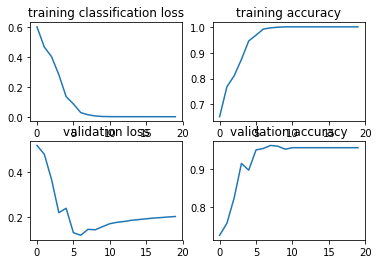

In [15]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train only adversary

In [16]:
from synthetic_dataloader import *
gender_train = GenderDataset(train_df)
gender_valid = GenderDataset(val_df)

In [17]:
advtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
advval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [18]:
adv_encoder = LeNet()
adversary = ClassNet()

In [19]:
adv_criterion = nn.BCELoss()
opt_adv = optim.Adam(adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
opt_adv_enc = optim.Adam(adv_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler_adv = lr_scheduler.StepLR(optimizer=opt_adv, gamma=0.99, step_size=1)
scheduler_adv_enc = lr_scheduler.StepLR(optimizer=opt_adv_enc, gamma=0.99, step_size=1)

In [20]:
num_epochs = 20
train_losses = []
train_accs = []
val_losses = []
val_accs = []
epoch_time = AverageMeter()
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))
        scheduler_adv_enc.step()
        scheduler_adv.step()
        # train
        train_loss, train_acc = train_encoder_classifier_epoch(advtrain_loader,adv_encoder,
                                adversary, opt_adv_enc,
                                opt_adv, adv_criterion, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # validate
        print('-'*10)
        val_loss, val_acc = validate_encoder_classifier_epoch(advval_loader, adv_encoder, adversary,
                                 adv_criterion, device)

        print('Avg validation loss: {} \t Accuracy: {}'.format(val_loss, val_acc))
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.860 (0.860)	Loss 0.6921 (0.6921)	Accuracy 0.5391 (0.5391)
Batch: [5/40]	Time 0.138 (0.280)	Loss 0.5078 (0.5855)	Accuracy 0.7578 (0.6745)
Batch: [10/40]	Time 0.042 (0.229)	Loss 0.3229 (0.4992)	Accuracy 0.8281 (0.7393)
Batch: [15/40]	Time 0.052 (0.207)	Loss 0.3169 (0.4356)	Accuracy 0.8750 (0.7739)
Batch: [20/40]	Time 0.318 (0.209)	Loss 0.1931 (0.3907)	Accuracy 0.8906 (0.8017)
Batch: [25/40]	Time 0.226 (0.207)	Loss 0.1531 (0.3528)	Accuracy 0.9453 (0.8230)
Batch: [30/40]	Time 0.048 (0.198)	Loss 0.1351 (0.3294)	Accuracy 0.9453 (0.8367)
Batch: [35/40]	Time 0.036 (0.191)	Loss 0.1404 (0.3061)	Accuracy 0.9219 (0.8485)
----------


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test: [0/4]	Time 0.888 (0.888)	Loss 0.0870 (0.0870)	Accuracy 0.9609 (0.9609)
Avg validation loss: 0.08582873657345771 	 Accuracy: 0.96
--------------------
Epoch 0/20	Time 8.348 sec (8.348 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.886 (0.886)	Loss 0.0849 (0.0849)	Accuracy 0.9688 (0.9688)
Batch: [5/40]	Time 0.148 (0.289)	Loss 0.0661 (0.0927)	Accuracy 0.9688 (0.9596)
Batch: [10/40]	Time 0.052 (0.232)	Loss 0.0862 (0.0785)	Accuracy 0.9688 (0.9666)
Batch: [15/40]	Time 0.052 (0.207)	Loss 0.0747 (0.0767)	Accuracy 0.9688 (0.9683)
Batch: [20/40]	Time 0.496 (0.215)	Loss 0.0502 (0.0684)	Accuracy 0.9766 (0.9714)
Batch: [25/40]	Time 0.110 (0.205)	Loss 0.0268 (0.0623)	Accuracy 1.0000 (0.9748)
Batch: [30/40]	Time 0.048 (0.196)	Loss 0.0279 (0.0578)	Accuracy 0.9844 (0.9771)
Batch: [35/40]	Time 0.035 (0.188)	Loss 0.0100 (0.0531)	Accuracy 1.0000 (0.9789)
----------
Test: [0/4]	Time 0.818 (0.818)	Loss 0.0365 (0.0365)	Accuracy 0.9844 (0.9844)
Avg validation loss: 0.036024877905845645 	 Accuracy: 0.988
--------------------
Epoch 1/20	Time 8.238 sec (8.293 sec)
--------------------
Epoch: 2/20
Batch: [0/40]	Time 0.939 (0.939)	Loss 0.0487 (0.0487)	Accuracy 0.9766 (0.9766)
Batch: [5/40]	Time 0.099 (0.275)	Loss 0.058

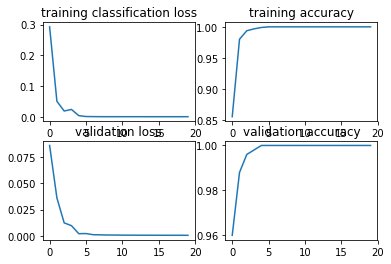

In [21]:
plt.subplot(221)
plt.title('training classification loss')
plt.plot(train_losses)
plt.subplot(222)
plt.title('training accuracy')
plt.plot(train_accs)
plt.subplot(223)
plt.title('validation loss')
plt.plot(val_losses)
plt.subplot(224)
plt.title('validation accuracy')
plt.plot(val_accs)

## Train adversary on original encoder

## LAFTR Training

In [22]:
from synthetic_dataloader import *
gender_train = ShapeGenderDataset(train_df)
gender_valid = ShapeGenderDataset(val_df)

In [23]:
laftrtrain_loader = DataLoader(gender_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
laftrval_loader = DataLoader(gender_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

In [24]:
laftr_encoder = LeNet()
laftr_adversary = ClassNet()
laftr_classifier = ClassNet()

In [25]:
laftr_adv_criterion = AdvDemographicParityLoss()
laftr_cls_criterion = nn.BCELoss()

In [26]:
laftr_opt_adv = optim.Adam(laftr_adversary.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_cls = optim.Adam(laftr_classifier.parameters(), lr=0.001, betas=(0.9, 0.999))
laftr_opt_enc = optim.Adam(laftr_encoder.parameters(), lr=0.001, betas=(0.9, 0.999))

laftr_scheduler_adv = lr_scheduler.StepLR(optimizer=laftr_opt_adv, gamma=0.99, step_size=1)
laftr_scheduler_cls = lr_scheduler.StepLR(optimizer=laftr_opt_cls, gamma=0.99, step_size=1)
laftr_scheduler_enc = lr_scheduler.StepLR(optimizer=laftr_opt_enc, gamma=0.99, step_size=1)

In [27]:
num_epochs = 20

clsTrain_losses = []
clsTrain_accs = []
clsTrainCombined_losses = []
advTrain_losses = []
advTrain_accs = []
advTrainCombined_losses = []

combinedVal_losses = []
clsVal_losses = []
clsVal_accs = []
advVal_losses = []
advVal_accs = []

epoch_time = AverageMeter()

In [28]:
ep_end = time.time()
for epoch in range(0, num_epochs):
        print('Epoch: {}/{}'.format(epoch, num_epochs))

        laftr_scheduler_adv.step()
        laftr_scheduler_cls.step()
        laftr_scheduler_enc.step()
        
        cls_loss, cls_en_combinedLoss, cls_en_acc, adv_loss, adv_combinedLoss, adv_acc = laftr_epoch_dp(laftrtrain_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, laftr_opt_enc,
                                                        laftr_opt_cls, laftr_opt_adv, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        clsTrain_losses.append(cls_loss)
        clsTrain_accs.append(cls_en_acc)
        clsTrainCombined_losses.append(cls_en_combinedLoss)
        advTrain_losses.append(adv_loss)
        advTrain_accs.append(adv_acc)
        advTrainCombined_losses.append(adv_combinedLoss)
        
        print('Classifier accuracy: {}\t Adversary Accuracy: {}'.format(cls_en_acc, adv_acc))
        # validate
        print('-'*10)
        
        combinedVal_loss, clsVal_loss, clsVal_acc, advVal_loss, advVal_acc = laftr_validate_dp(laftrval_loader,
                                                        laftr_encoder, laftr_classifier, laftr_adversary, 
                                                        laftr_cls_criterion, laftr_adv_criterion, device)
        
        combinedVal_losses.append(combinedVal_loss)
        clsVal_losses.append(clsVal_loss)
        clsVal_accs.append(clsVal_acc)
        advVal_losses.append(advVal_loss)
        advVal_accs.append(advVal_acc)
        
        print('Classifier validation acc: {:.4f} \t Adv validation acc: {:.4f}'.format(clsVal_acc, advVal_acc))
        
        print('-' * 20)
        epoch_time.update(time.time() - ep_end)
        ep_end = time.time()
        print('Epoch {}/{}\t'
              'Time {epoch_time.val:.3f} sec ({epoch_time.avg:.3f} sec)'.format(epoch, num_epochs, epoch_time=epoch_time))
        print('-'*20)

Epoch: 0/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.969 (0.969)
Classifier loss 0.6973 (0.6973)	Adversary loss -0.0458 (-0.0458)
Combined Loss during classifier step 0.6970 (0.6970)	Combined Loss during adversary step -0.6292 (-0.6292)
Classifier Accuracy 0.4453 (0.4453)	Adversary Accuracy 0.3047 (0.3047)
Batch: [5/40]	Time 0.078 (0.271)
Classifier loss 0.6931 (0.6942)	Adversary loss -0.6262 (-0.3466)
Combined Loss during classifier step 0.1651 (0.4645)	Combined Loss during adversary step -0.0729 (-0.3145)
Classifier Accuracy 0.5469 (0.5417)	Adversary Accuracy 0.0859 (0.1654)
Batch: [10/40]	Time 0.053 (0.221)
Classifier loss 0.5839 (0.6786)	Adversary loss -0.6925 (-0.4834)
Combined Loss during classifier step -0.0584 (0.2857)	Combined Loss during adversary step 0.1013 (-0.1643)
Classifier Accuracy 0.6562 (0.5661)	Adversary Accuracy 0.0781 (0.1442)
Batch: [15/40]	Time 0.065 (0.207)
Classifier loss 0.7358 (0.6830)	Adversary loss -0.6010 (-0.5313)
Combined Loss during classifier step 0.3945 (0.2515)	Combined Loss durin

/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Test batch: [0/4]	Time 0.865 (0.865)
Classifier loss 0.6759 (0.6759)	Adversary loss -0.0038 (-0.0038)
Combined Loss 0.6721 (0.6721)	Classifier Accuracy 0.6094 (0.6094)	Adversary Accuracy 0.5547 (0.5547)
Classifier validation acc: 0.5760 	 Adv validation acc: 0.5200
--------------------
Epoch 0/20	Time 8.316 sec (8.316 sec)
--------------------
Epoch: 1/20


/home/var/anaconda3/envs/diss/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([116])) that is different to the input size (torch.Size([116, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Batch: [0/40]	Time 0.975 (0.975)
Classifier loss 0.6066 (0.6066)	Adversary loss -0.0035 (-0.0035)
Combined Loss during classifier step 0.6035 (0.6035)	Combined Loss during adversary step -0.6497 (-0.6497)
Classifier Accuracy 0.6484 (0.6484)	Adversary Accuracy 0.5703 (0.5703)
Batch: [5/40]	Time 0.068 (0.282)
Classifier loss 0.5783 (0.6444)	Adversary loss -0.0068 (-0.0055)
Combined Loss during classifier step 0.5727 (0.6397)	Combined Loss during adversary step -0.5402 (-0.6122)
Classifier Accuracy 0.7344 (0.6641)	Adversary Accuracy 0.5000 (0.5156)
Batch: [10/40]	Time 0.054 (0.236)
Classifier loss 0.4912 (0.5969)	Adversary loss -0.0164 (-0.0082)
Combined Loss during classifier step 0.4777 (0.5900)	Combined Loss during adversary step -0.4751 (-0.5650)
Classifier Accuracy 0.7422 (0.6889)	Adversary Accuracy 0.4609 (0.4993)
Batch: [15/40]	Time 0.075 (0.215)
Classifier loss 0.4647 (0.5888)	Adversary loss -0.0191 (-0.0117)
Combined Loss during classifier step 0.4519 (0.5796)	Combined Loss durin

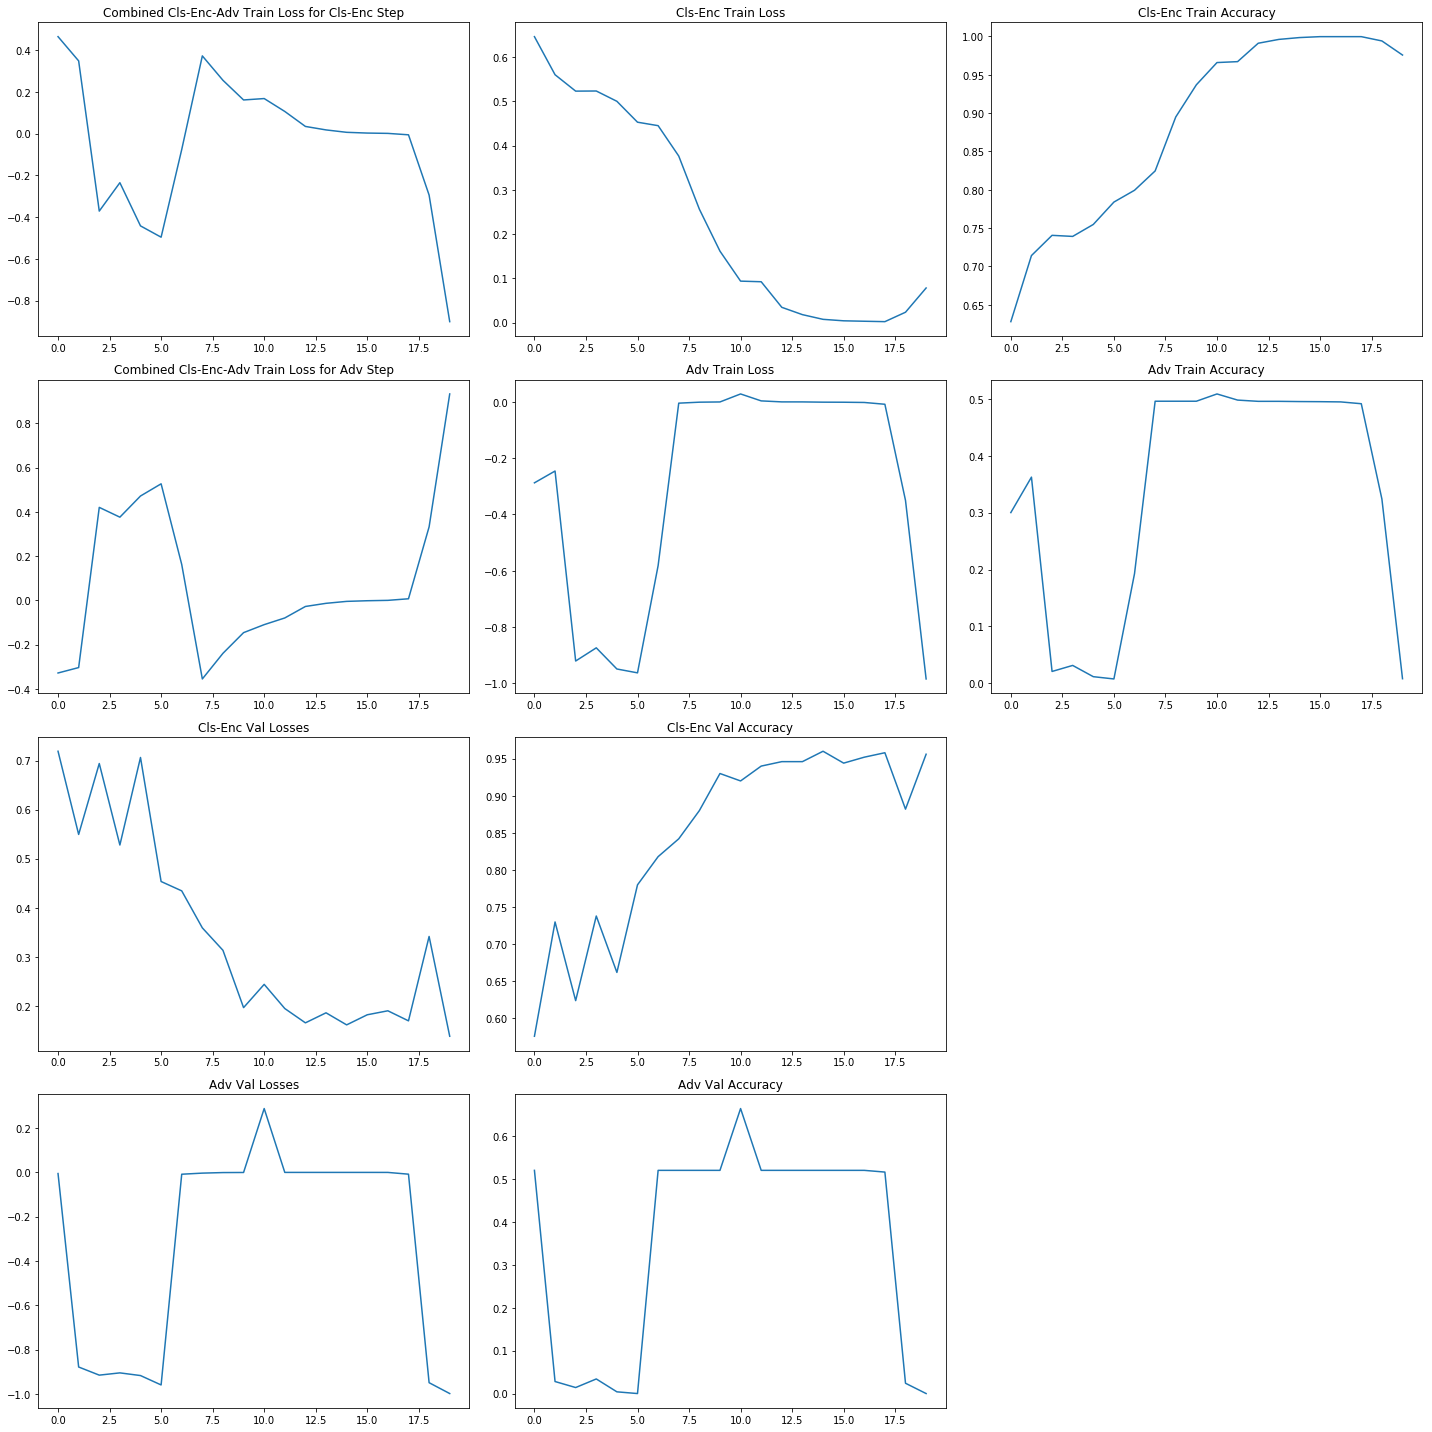

In [29]:
plt.figure(figsize=(20,20))
plt.subplot(431)
plt.title('Combined Cls-Enc-Adv Train Loss for Cls-Enc Step')
plt.plot(clsTrainCombined_losses)
plt.subplot(432)
plt.title('Cls-Enc Train Loss')
plt.plot(clsTrain_losses)
plt.subplot(433)
plt.title('Cls-Enc Train Accuracy')
plt.plot(clsTrain_accs)
plt.subplot(434)
plt.title('Combined Cls-Enc-Adv Train Loss for Adv Step')
plt.plot(advTrainCombined_losses)
plt.subplot(435)
plt.title('Adv Train Loss')
plt.plot(advTrain_losses)
plt.subplot(436)
plt.title('Adv Train Accuracy')
plt.plot(advTrain_accs)

plt.subplot(437)
plt.title('Cls-Enc Val Losses')
plt.plot(clsVal_losses)
plt.subplot(438)
plt.title('Cls-Enc Val Accuracy')
plt.plot(clsVal_accs)
plt.subplot(4,3,10)
plt.title('Adv Val Losses')
plt.plot(advVal_losses)
plt.subplot(4,3,11)
plt.title('Adv Val Accuracy')
plt.plot(advVal_accs)

plt.tight_layout()

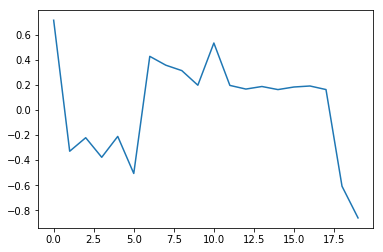

In [30]:
plt.plot(combinedVal_losses)